In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [2]:
%load_ext autoreload
%autoreload 2

## Load SXR phantoms

In [6]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples/psis.npy')
sxr_samples = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas = np.load('../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_val = np.load('../dataset_generation/sxr_samples/trimming_values.npy')

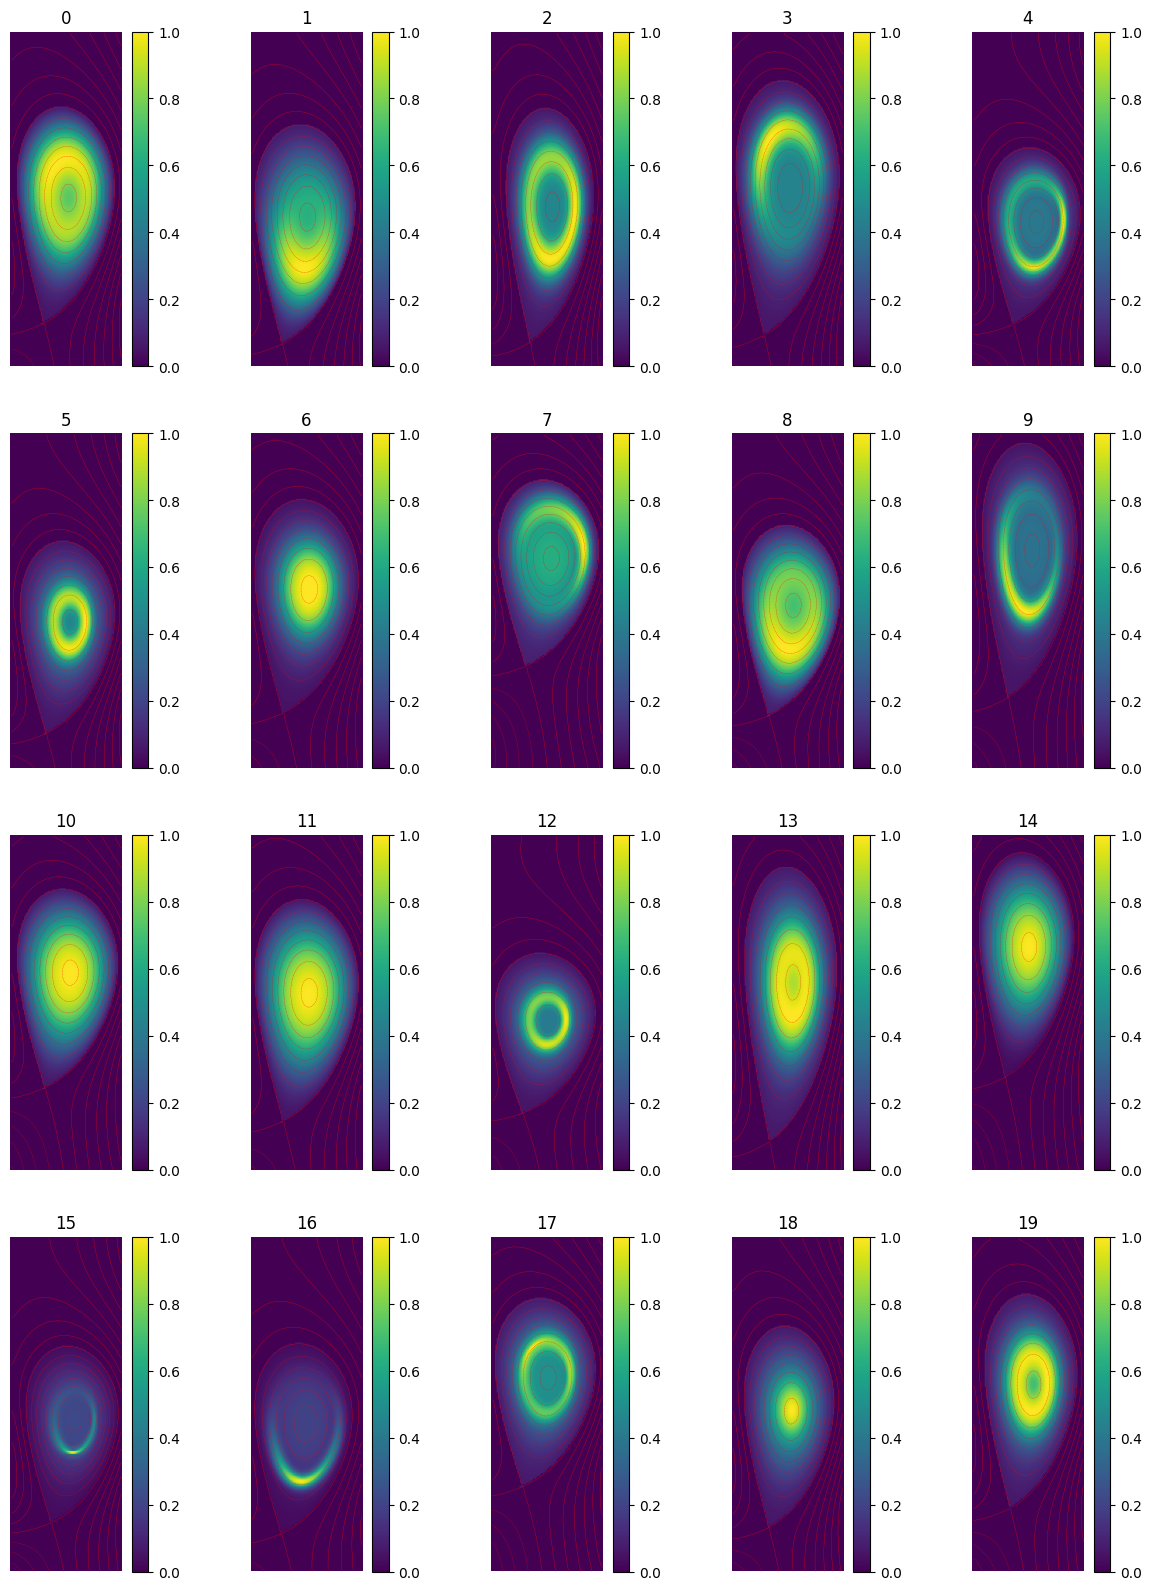

In [7]:
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        im=ax[i,j].imshow(sxr_samples[i*5+j, :, :].squeeze())
        ax[i, j].contour(psis[i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(i*5+j))
plt.show()

In [5]:
def add_gaussian_background(ground_truth, psi, mask, peak_value_gaussian=0):
    sigma_gaussian_normalized_radius = 0.5
    gaussian_profile = peak_value_gaussian * np.exp( -( (psi-np.min(psi))/(np.min(psi)) )**2 / (2*sigma_gaussian_normalized_radius**2))
    gaussian_profile *= mask
    ground_truth_new = ground_truth + gaussian_profile
    ground_truth_new /= np.max(ground_truth_new)
    return ground_truth_new

In [6]:
psis[id, :, :].shape

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [7]:
samples_new = np.zeros(sxr_samples.shape) 

seed = 0
peak_value_min = 0.2
peak_value_max = 1
peak_vals = 0.2 + 0.8 * np.random.rand(samples_new.shape[0])
np.random.seed(seed)
for id in range(samples_new.shape[0]):
    mask_core_ = tomo_helps.define_core_mask(psi=psis[id, :, :], dim_shape=psis[id, :, :].shape, trim_values_x=trim_val[id, :])
    samples_new[id, :, :] = add_gaussian_background(sxr_samples[id, :, :].squeeze(), psis[id, :, :], mask_core_, peak_vals[id])

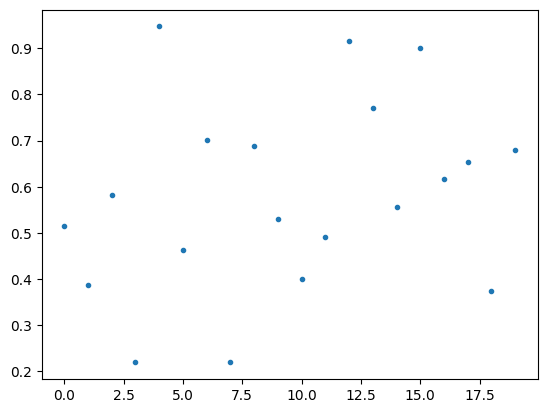

In [8]:
plt.plot(peak_vals[:20], '.')

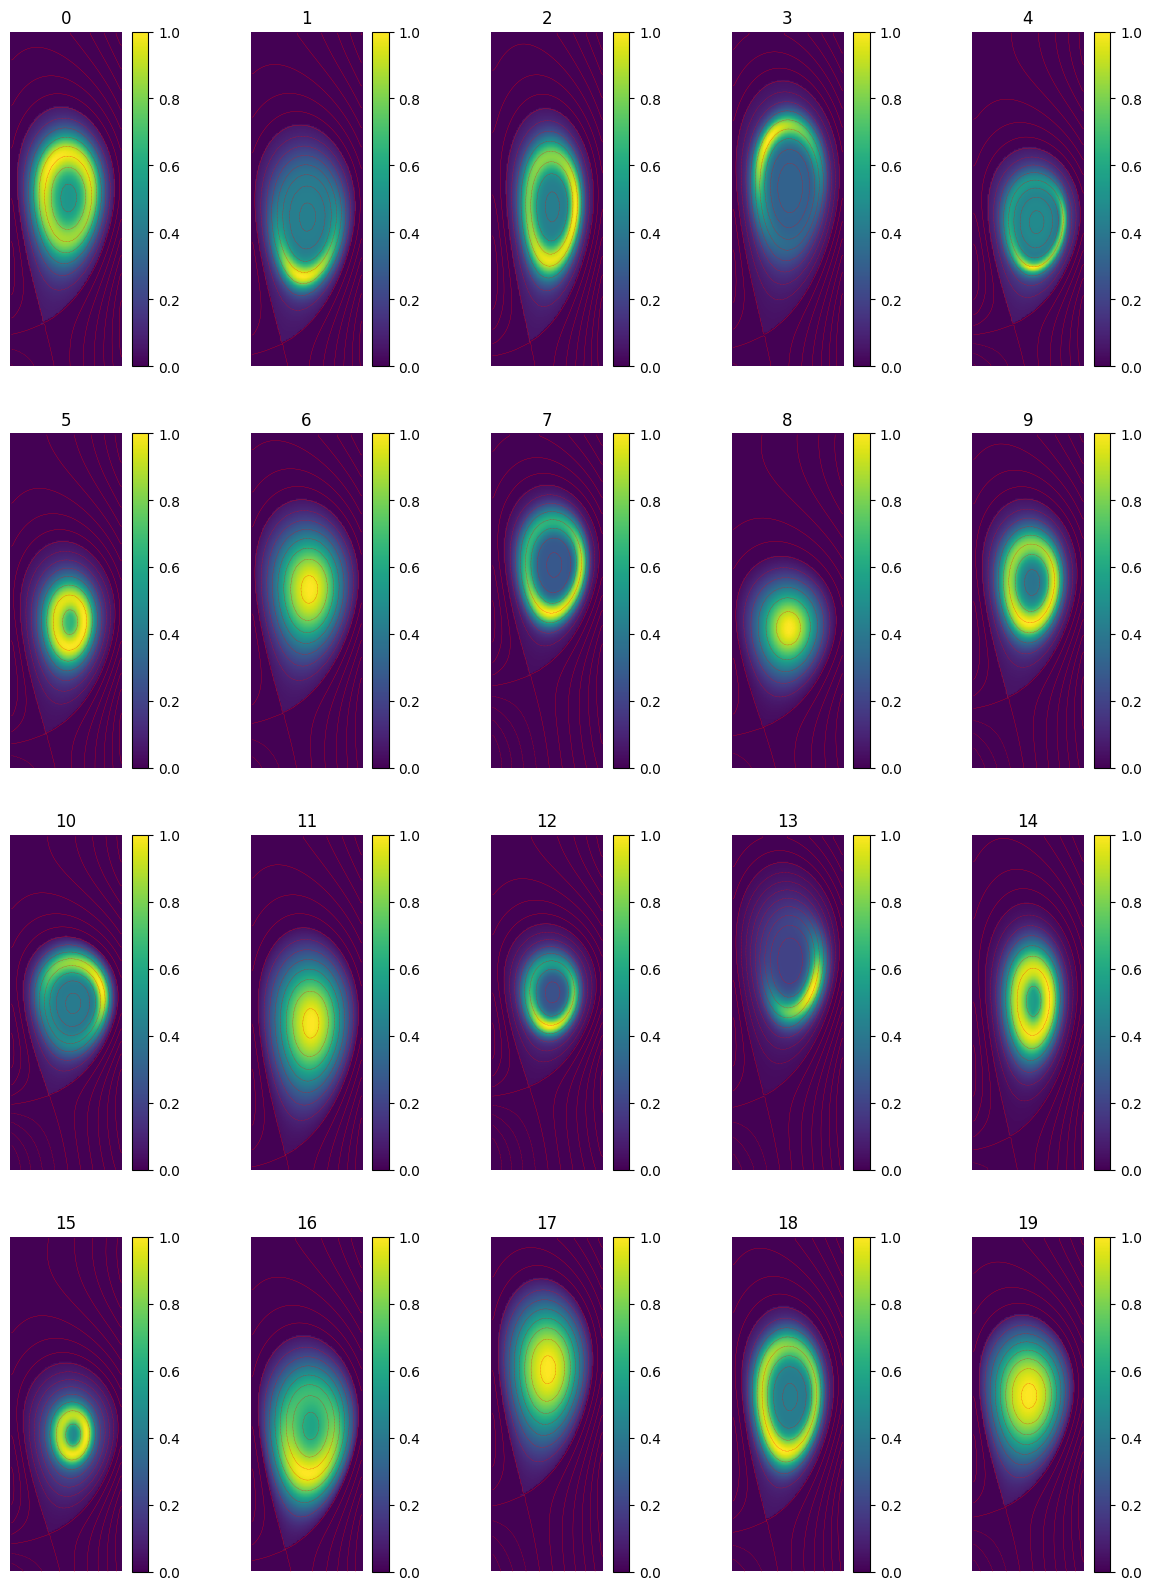

In [49]:
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        im=ax[i,j].imshow(samples_new[i*5+j, 0, :, :].squeeze())
        ax[i, j].contour(psis[i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(i*5+j))
plt.show()

In [51]:
# Load phantom data
np.save('../dataset_generation/sxr_samples_fine_gaussian_background/sxr_samples.npy', samples_new)
np.save('../dataset_generation/sxr_samples_fine_gaussian_background/peak_values.npy', peak_vals)

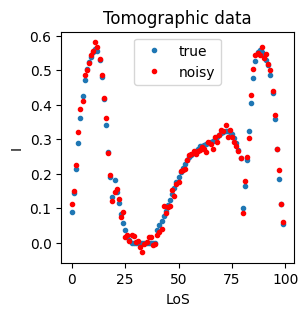

In [74]:
reg_fct_type = "anisotropic"
reg_fct_type = "coherence_enhancing"
# Define functionals
sig=1.4e-2
f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=sxr_samples[0,:,:], psi=psis[0,:,:], sigma_err=1.4e-2, reg_fct_type=reg_fct_type, alpha=1e-2, plot=True)
mask_core = tomo_helps.define_core_mask(psi=psis[0,:,:], dim_shape=(120,40), trim_values_x=trim_val[0,:])

In [1065]:
# fig,ax=plt.subplots(4,5, figsize=(15,20))
# block = 1
# for i in range(4):
#     for j in range(5):
#         im=ax[i,j].imshow(sxr_samples_coarse[20*block + i*5+j, 0, :, :].squeeze())
#         ax[i, j].contour(psis_coarse[20*block + i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
#         plt.colorbar(im, ax=ax[i,j])
#         ax[i,j].axis('off')
#         ax[i,j].set_title("{}".format(20*block + i*5+j))
# plt.show()

In [1188]:
lambdas=np.logspace(-5,0,6)
lambdas

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [1211]:
covs = []
for ll in lambdas:
    mat_ = 1e4 * f.forward_model_linop.mat.T @ f.forward_model_linop.mat+ ll * g._grad_matrix_based.mat
    inv_mat = np.linalg.inv(mat_.toarray())
    covs.append(inv_mat)

In [27]:
sigma_err_vec=7e-3+0.05*f.tomo_data

In [29]:
fmatnew=f.forward_model_linop.mat / (np.hstack([sigma_err_vec.reshape(-1,1)]*4800))

In [75]:
mat_ = f.forward_model_linop.mat.T @ f.forward_model_linop.mat / (sig**2) + 0.1 * g._grad_matrix_based.mat
inv_mat = np.linalg.inv(mat_.toarray())
mat_1 = f.forward_model_linop.mat.T @ f.forward_model_linop.mat / ((sig/2)**2) + 0.1 * g._grad_matrix_based.mat
inv_mat1 = np.linalg.inv(mat_1.toarray())
mat_2 = fmatnew.T @ fmatnew + 0.1 * g._grad_matrix_based.mat
inv_mat2 = np.linalg.inv(mat_2.toarray())

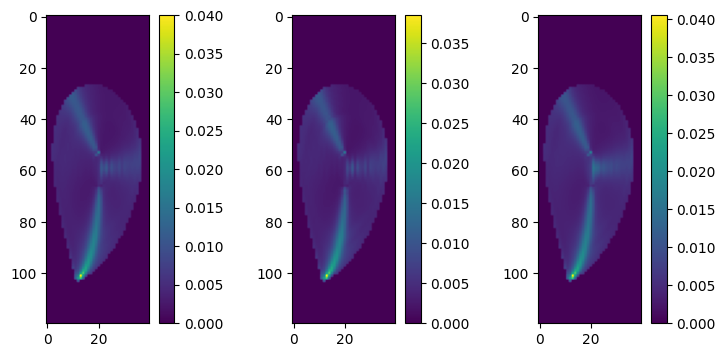

In [76]:
fig,ax=plt.subplots(1,3, figsize=(9,4))
p=ax[0].imshow(mask_core*np.diag(inv_mat).reshape(120,40))
plt.colorbar(p, ax=ax[0])
p=ax[1].imshow(mask_core*np.diag(inv_mat1).reshape(120,40))
plt.colorbar(p, ax=ax[1])
p=ax[2].imshow(mask_core*np.diag(inv_mat2).reshape(120,40))
plt.colorbar(p, ax=ax[2])

In [36]:
print(np.linalg.norm(inv_mat-inv_mat1), np.linalg.norm(inv_mat-inv_mat2), np.linalg.norm(inv_mat1-inv_mat2))

0.560798195291555 0.6116695058079101 1.0210790529804727


In [39]:
print(np.linalg.norm(inv_mat-inv_mat1, 2), np.linalg.norm(inv_mat-inv_mat2, 2), np.linalg.norm(inv_mat1-inv_mat2, 2))

0.3040589109229443 0.39009908215328565 0.6349254265489965


In [40]:
g._grad_matrix_based.mat.shape

(4800, 4800)

In [43]:
np.linalg.matrix_rank(g._grad_matrix_based.mat.toarray())

np.int64(4799)

In [44]:
from scipy.linalg import null_space
ns=null_space(g._grad_matrix_based.mat.toarray())

In [45]:
ns.shape

(4800, 1)

In [46]:
np.linalg.norm(ns)

np.float64(1.0000000000000002)

In [47]:
nm=g._grad_matrix_based.mat.toarray()+1e-6*(ns.reshape(-1,1)@ns.reshape(1,-1))

In [48]:
np.linalg.matrix_rank(nm)

np.int64(4800)

In [52]:
inv_mat_nm = np.linalg.inv(f.forward_model_linop.mat.T @ f.forward_model_linop.mat / ((sig/2)**2) + 0.1*nm)

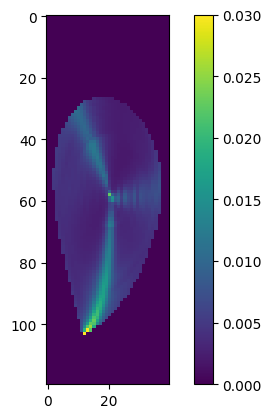

In [55]:
plt.imshow(mask_core*np.diag(inv_mat_nm).reshape(120,40), vmax=0.03)
plt.colorbar()

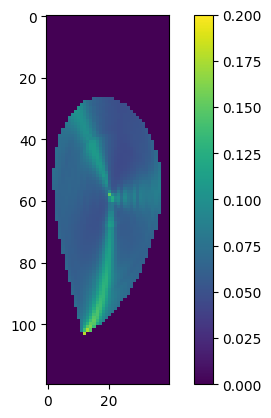

In [65]:
plt.imshow(mask_core*np.sqrt(np.diag(inv_mat_nm)).reshape(120,40), vmax=0.2)
plt.colorbar()

In [70]:
np.max(np.diag(np.linalg.inv(0.1*nm)))

np.float64(2083.519430395692)

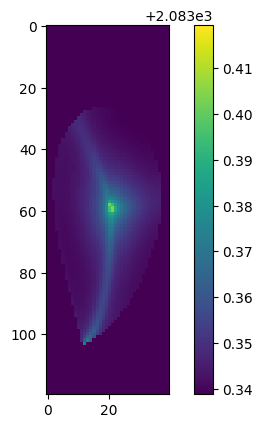

In [73]:
plt.imshow(mask_core*np.diag(np.linalg.inv(0.1*nm)).reshape(120,40), vmax=2083.41943, vmin=2083.33885)
plt.colorbar()

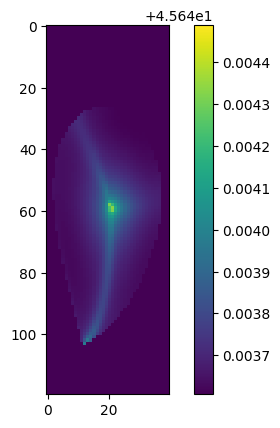

In [77]:
plt.imshow(mask_core*np.sqrt(np.diag(np.linalg.inv(0.1*nm))).reshape(120,40), vmax=np.sqrt(2083.41943), vmin=np.sqrt(2083.33885))
plt.colorbar()

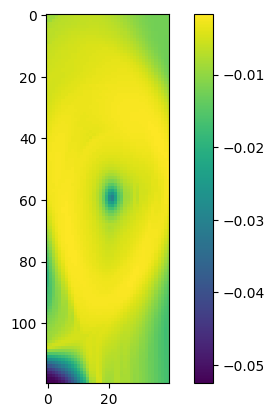

In [24]:
plt.imshow(np.diag(inv_mat).reshape(120,40)-np.diag(inv_mat1).reshape(120,40))
plt.colorbar()

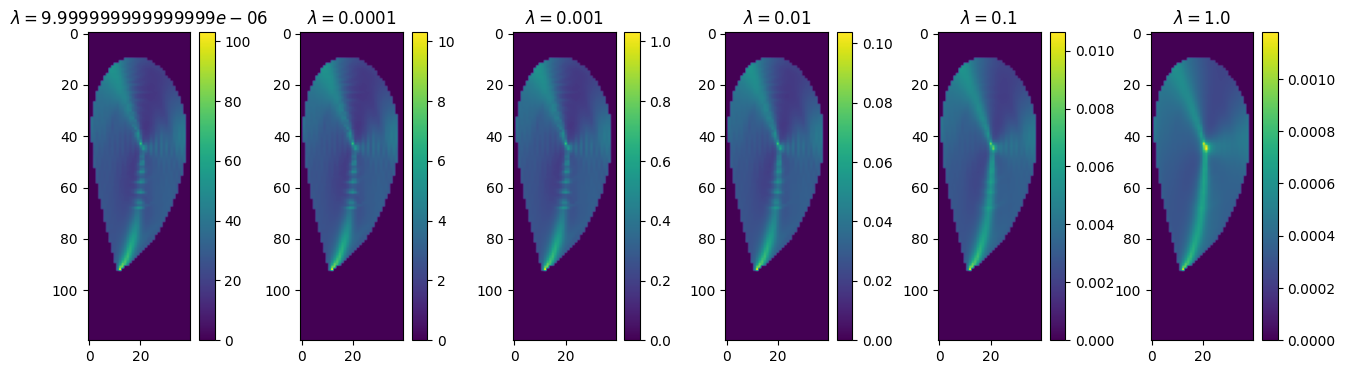

In [1215]:
fig,ax=plt.subplots(1,6, figsize=(16,4))
for i in range(6):
    p=ax[i].imshow(mask_core*np.diag(covs[i]).reshape(120,40))
    plt.colorbar(p, ax=ax[i])
    ax[i].set_title(r"$\lambda={}$".format(lambdas[i]))

In [1227]:
lambdas_small=np.logspace(1,6,6)
lambdas

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [1230]:
covs_small = []
for ll in lambdas_small:
    print(ll)
    mat_ = 1e4 * f.forward_model_linop.mat.T @ f.forward_model_linop.mat + ll * g._grad_matrix_based.mat
    inv_mat = np.linalg.inv(mat_.toarray())
    covs_small.append(inv_mat)

10.0
100.0
1000.0
10000.0
100000.0
1000000.0


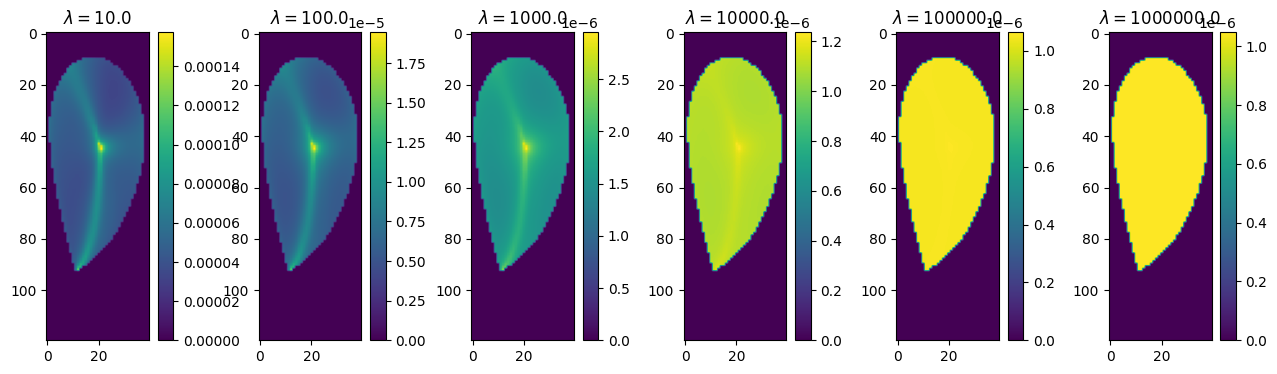

In [1231]:
fig,ax=plt.subplots(1,6, figsize=(16,4))
for i in range(6):
    p=ax[i].imshow(mask_core*np.diag(covs_small[i]).reshape(120,40))
    plt.colorbar(p, ax=ax[i])
    ax[i].set_title(r"$\lambda={}$".format(lambdas_small[i]))

# Hyperparameter tuning

We run hyperparameter tuning techniques on 100 SXR phantoms.

In [12]:
idx = 18
ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
psi=psis[idx,:,:]
alpha=alphas[idx]
trim_val_=trim_val[idx,:]
recon_shape = (120,40)
mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)
mask_tcv = tomo_helps.define_tcv_mask(dim_shape=recon_shape)

# background_em = 0.025
# additive_term = background_em / (1-background_em)
# ground_truth += additive_term * mask_core_fine
# ground_truth /= np.max(ground_truth)

In [ ]:
def add_gaussian(ground_truth, psi):
    gaussian_profile = np.zeros(ground_truth.shape)
    sigma_gaussian_normalized_radius = 0.5
    peak_value_gaussian = 1
    for i in range(ground_truth.shape[0]):
        for j in range(ground_truth.shape[1]):
            if mask_core_fine[i,j]:
                gaussian_profile[i, j] = peak_value_gaussian * np.exp( -( (psi[i,j]-np.min(psi))/(np.min(psi)) )**2 / (2*sigma_gaussian_normalized_radius**2))
                
    ground_truth_new = ground_truth + gaussian_profile
    ground_truth_new /= np.max(ground_truth_new)
    return ground_truth_new

In [11]:
to_be_added = np.zeros(ground_truth.shape)
sigma_additive_gaussian_normalized = 0.5
peak_additive_gaussian = 1

for i in range(ground_truth.shape[0]):
    for j in range(ground_truth.shape[1]):
        if mask_core_fine[i,j]:
            to_be_added[i, j] = peak_additive_gaussian * np.exp( -( (psi[i,j]-np.min(psi))/(np.min(psi)) )**2 / (2*sigma_additive_gaussian_normalized**2))
            
ground_truth += to_be_added
ground_truth /= np.max(ground_truth)

NameError: name 'ground_truth' is not defined

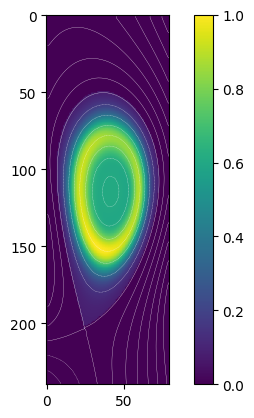

In [1263]:
plt.imshow(ground_truth)
plt.colorbar()
plt.contour(psi, origin="lower", levels=15, antialiased=True, colors="w", linewidths=0.2)

In [1264]:
np.min(ground_truth[mask_core_fine])

np.float64(0.0822977480543417)

In [13]:
fwd_fine=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr_fine_grid.npz')
fwd_coarse=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz')
tomo_data = fwd_fine.dot(ground_truth.flatten())
# plt.plot(tomo_data)
# plt.plot(np.ones(tomo_data.size)*np.mean(tomo_data))
sigma_err = 0.1 * np.mean(tomo_data)
print("sigma_err = {:.2e}".format(sigma_err))
sigma_err=1e-2

sigma_err = 1.38e-02


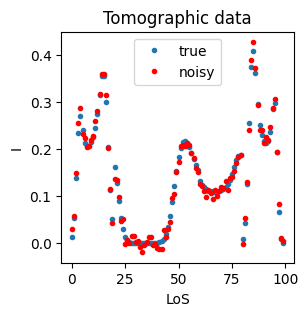

In [14]:
reg_fct_type = "anisotropic"
# Define functionals
f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi, sigma_err=sigma_err, reg_fct_type=reg_fct_type, alpha=alpha, plot=True)

## Hyperparameter tuning

**Regularization parameter**

Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



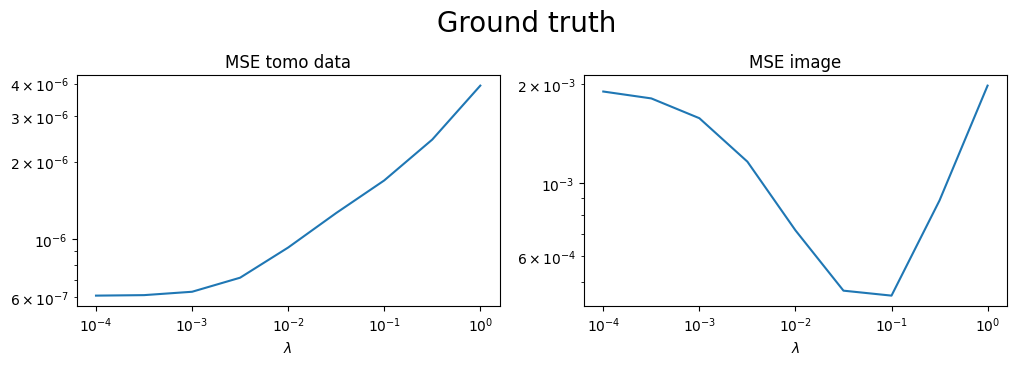

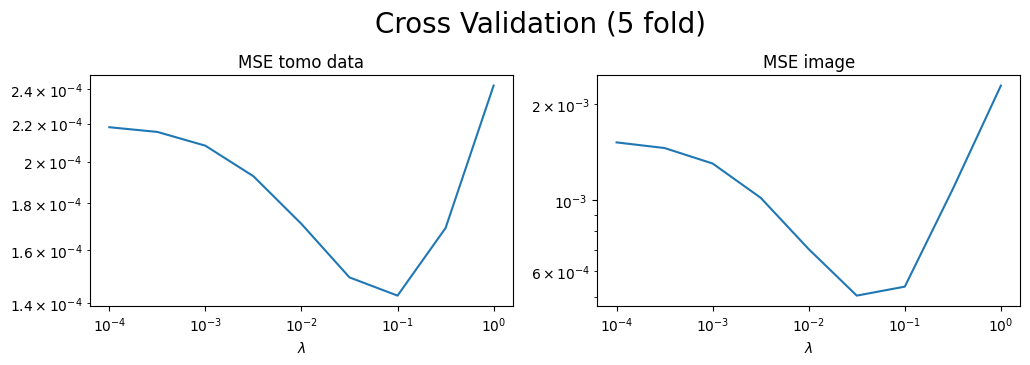

In [903]:
# Tune regularization parameter
#reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["SAPG"],
#                                                    sapg_max_iter=int(1e4), reg_params=np.logspace(-6,0,7), plot=True)
reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["GT", "CV_full"], ground_truth=ground_truth,
                                                    with_pos_constraint=True, clipping_mask=mask_core,
                                                    cv_strategy="random",
                                                    reg_params=np.logspace(-4,0,9), plot=True)


**Anisotropic Parameter**

Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



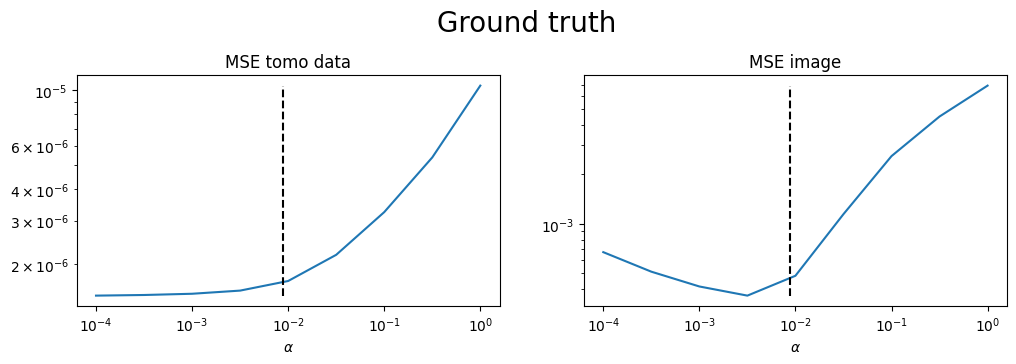

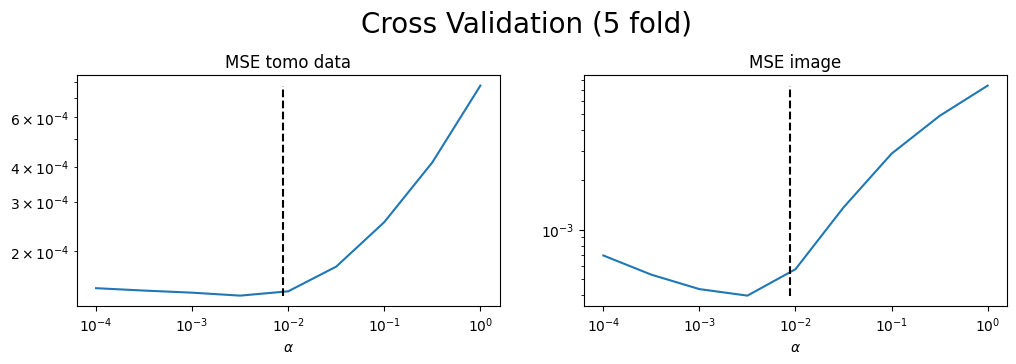

In [752]:
anis_param_tuning_data = hyper_tune.anis_param_tuning(f, g, reg_param=0.1,
                                                        tuning_techniques=["GT", "CV_full"], ground_truth=ground_truth,
                                                        with_pos_constraint=True, clipping_mask=mask_core,
                                                        cv_strategy="random",
                                                        anis_params=np.logspace(-4,0,9), plot=True)

In [753]:
g = hyper_tune._redefine_anis_param_logprior(g, anis_param_tuning_data["CV_full"][0, np.argmin(anis_param_tuning_data["CV_full"][1,:])])
#g = hyper_tune._redefine_anis_param_logprior(g, 1e-3)

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


In [15]:
g.diffusion_coefficient.alpha

np.float64(0.003521114124740236)

In [19]:
tt=time.time()
im_MAP = bcomp.compute_MAP(f, g, 0.1, with_pos_constraint=True, clipping_mask=mask_core)
print(time.time()-tt)

INFO -- [2024-12-19 14:41:19.615845] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-19 14:41:19.955883] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-19 14:41:20.056053] Iteration 1_337
	iteration: 1337
	N_iter: 1338
	RelError[x]: 0
INFO -- [2024-12-19 14:41:20.056957] Stopping Criterion satisfied -> END
0.4457240104675293


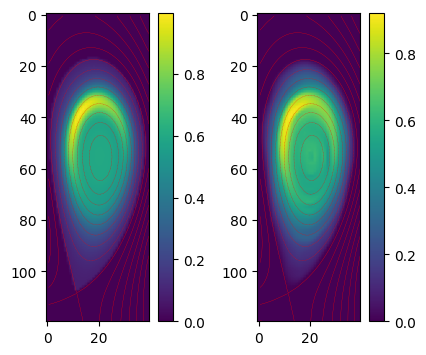

In [1077]:
fig,ax=plt.subplots(1,2,figsize=(5,4))
# im=ax[0].imshow(ground_truth.squeeze())
# plt.colorbar(im, ax=ax[0])
# ax[0].contour(psi, origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[0].imshow(skimt.resize(ground_truth.squeeze(), f.dim_shape[1:], anti_aliasing=False, mode='edge'))
plt.colorbar(im, ax=ax[0])
ax[0].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[1].imshow((im_MAP).squeeze())
plt.colorbar(im, ax=ax[1])
ax[1].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
plt.show()

In [1019]:
print(np.min(im_MAP), np.max(im_MAP))

0.0 1.0072081948382565


# Uncertainty Quantification

In [1150]:
uq_data = bcomp.run_ula(f, g, 0.1, psi, trim_val_,
            with_pos_constraint=True,
            clip_iterations="core",
            compute_stats_wrt_MAP=True,
            estimate_quantiles=True)

INFO -- [2024-12-16 13:36:11.808098] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-16 13:36:12.124062] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-16 13:36:12.266593] Iteration 1_414
	iteration: 1414
	N_iter: 1415
	RelError[x]: 0
INFO -- [2024-12-16 13:36:12.267315] Stopping Criterion satisfied -> END
Running 100000 ULA iterations
iteration  10000
iteration  20000
iteration  30000
iteration  40000
iteration  50000
iteration  60000
iteration  70000
iteration  80000
iteration  90000
iteration  100000


In [1151]:
print(uq_data["mean_peak_loc"], np.sqrt(uq_data["var_peak_loc"]), np.array(np.where(ground_truth==ground_truth.max()))/2)

[76.32214 24.84582] [9.02881309 4.92799234] [[84.5]
 [21.5]]


In [1152]:
import src.tomo_fusion.tools.plotting_fcts as tomo_plots

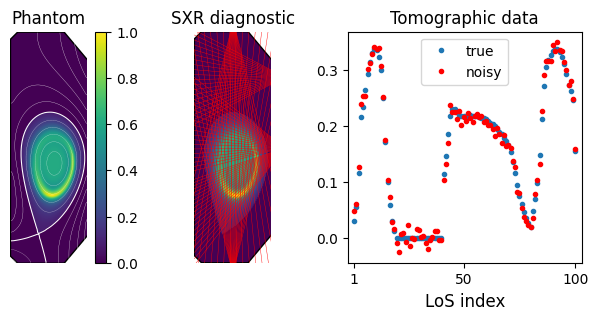

In [1153]:
tomo_plots.plot_phantom_and_sxr_diag(ground_truth=ground_truth, psi=psi, f=f, tcv_plot_clip=True)

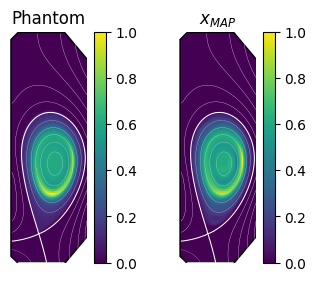

In [1154]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True)

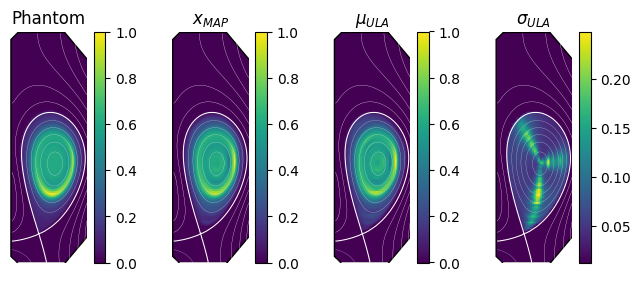

In [1155]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True,
                        cmaps=["viridis", "viridis", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

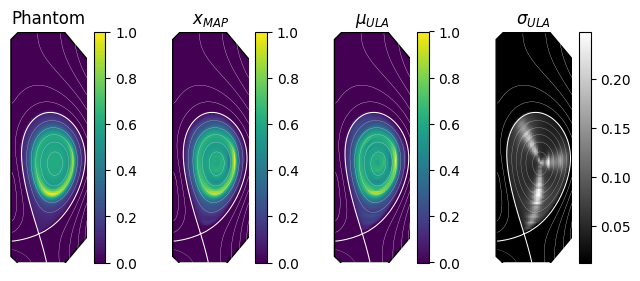

In [1156]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True,
                        cmaps=["viridis", "viridis", "viridis", "gray"], vmax_std=np.max(np.sqrt(uq_data["var"])))

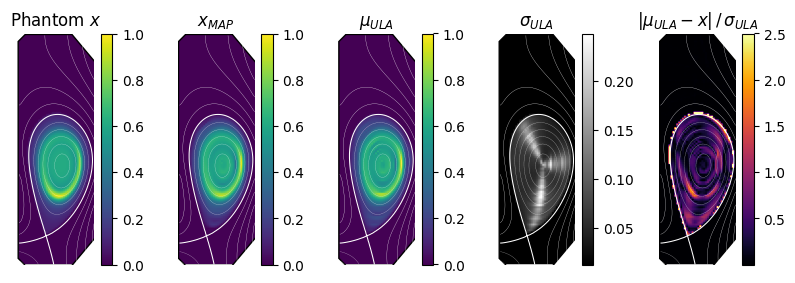

In [1157]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_nb_stds=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "inferno"],
                        vmax_std=np.max(np.sqrt(uq_data["var"])), vmax_nb_std=2.5)

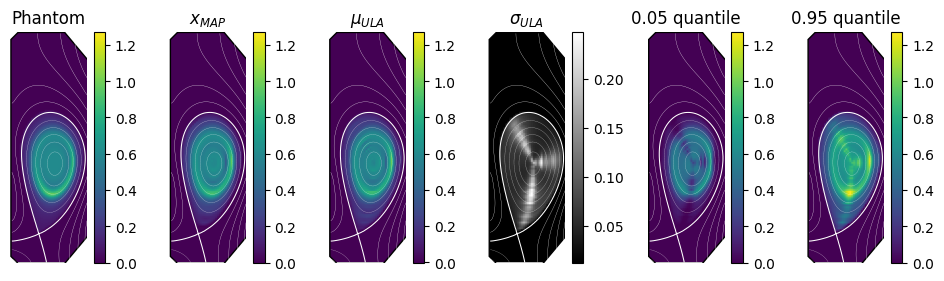

In [1158]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"],
                        vmax_std=np.max(np.sqrt(uq_data["var"])), vmax_adjust_if_quantile=True)

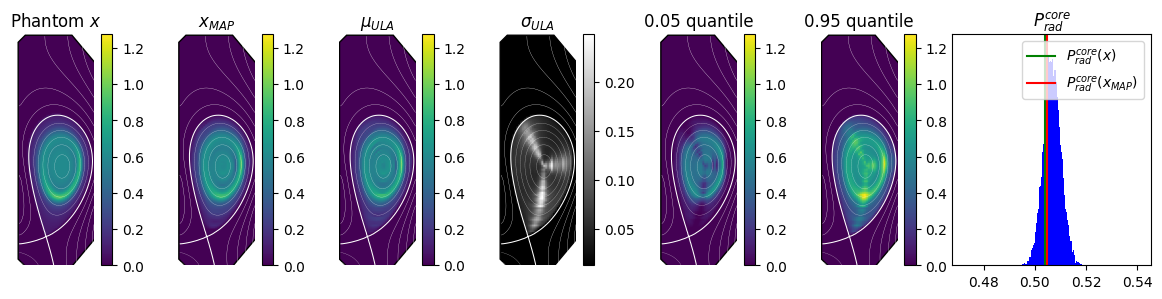

In [1159]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True, plot_prad=True,
                        mask_core=mask_tcv,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

In [1160]:
pradtrue=tomo_helps.compute_radiated_power(skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge'), mask_core, uq_data["sampling"])
print(pradtrue)

0.5022720556363013


In [1142]:
uq_data["mean_prad_core"]-np.sqrt(uq_data["var_prad_core"])

array([0.28609593])

In [1144]:
(uq_data["mean_prad_core"]-np.sqrt(uq_data["var_prad_core"])-pradtrue)/pradtrue

array([0.02563758])

In [1031]:
mask_core_fine = tomo_helps.define_core_mask(psi, ground_truth.squeeze().shape, trim_values_x=trim_val_)
mask_tcv_fine = tomo_helps.define_tcv_mask(ground_truth.squeeze().shape)

In [1032]:
prad_core_fine = tomo_helps.compute_radiated_power(ground_truth,mask_core_fine,sampling=0.0125/2)
prad_tcv_fine = tomo_helps.compute_radiated_power(ground_truth,mask_tcv_fine,sampling=0.0125/2)
print(prad_core_fine, prad_tcv_fine)
print(uq_data["prad_map_core"], uq_data["prad_map_tcv"])

0.3750832953924928 0.3750832953924928
0.37611377423534326 0.37611377423534326


In [1182]:
gt_coarse = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][1,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-2,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print(frac_pixels_within_quantiles, frac_pixels_within_quantiles_core)

0.5022916666666667 -0.0693822739480752


In [1183]:
gt_coarse = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][0,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-1,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print(frac_pixels_within_quantiles, frac_pixels_within_quantiles_core)

0.5427083333333333 0.017457475380483437


In [1184]:
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][2,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-3,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print(frac_pixels_within_quantiles, frac_pixels_within_quantiles_core)

0.455625 -0.16965085049239034


In [831]:
frac_pixels_within_quantiles = idxs[0].size / 4800

In [832]:
frac_pixels_within_quantiles

0.84625

In [514]:
uq_data.keys()

dict_keys(['tomo_data', 'noisy_tomo_data', 'sigma_err', 'reg_param', 'sampling', 'alpha', 'with_pos_constraint', 'clip_iterations', 'samples', 'burn_in', 'thinning_factor', 'quantile_marks', 'mean', 'var', 'mean_prad_tcv', 'var_prad_tcv', 'mean_prad_core', 'var_prad_core', 'prads_tcv', 'prads_core', 'mean_tomo_data', 'var_prad_data', 'im_MAP', 'prad_map_tcv', 'prad_map_core', 'var_wrtMAP', 'var_prad_wrtMAP_tcv', 'var_prad_wrtMAP_core', 'empirical_quantiles'])

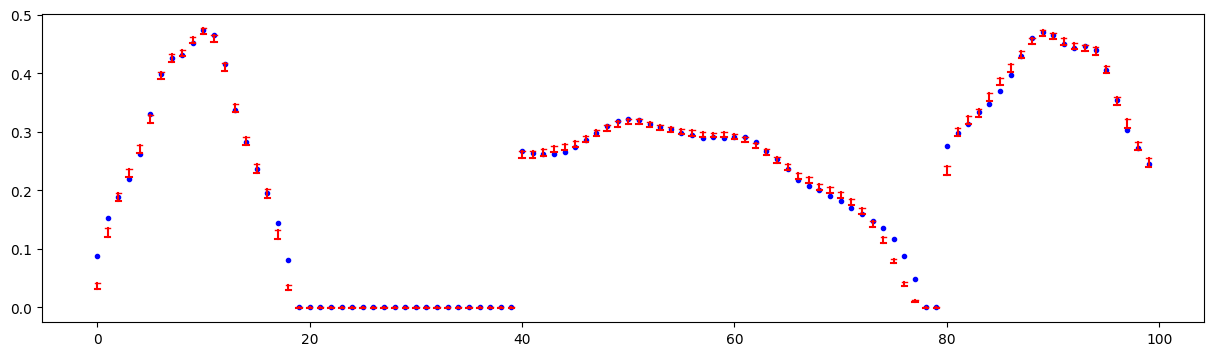

In [897]:
plt.figure(figsize=(15,4))
plt.plot(uq_data["tomo_data"], 'b.')
for i in range(uq_data["tomo_data"].size):
    tomo_plots.plot_errbar(i, uq_data["mean_tomo_data"][i], np.sqrt(uq_data["var_tomo_data"][i]),
                           left=0.25, right=0.25, linewidth=1)

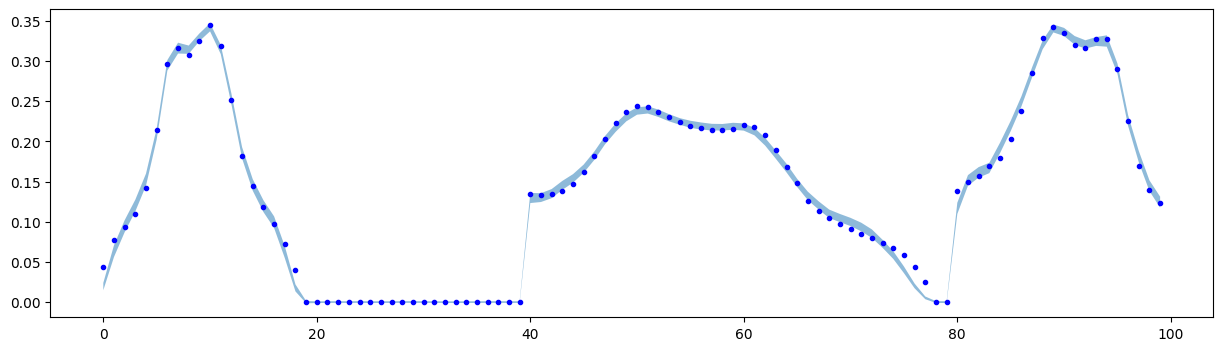

In [863]:
plt.figure(figsize=(15,4))
plt.plot(uq_data["tomo_data"], 'b.')
plt.fill_between(np.arange(0,100),
                 uq_data["mean_tomo_data"]-np.sqrt(uq_data["var_tomo_data"]),
                 uq_data["mean_tomo_data"]+np.sqrt(uq_data["var_tomo_data"]),
                 alpha=0.5)

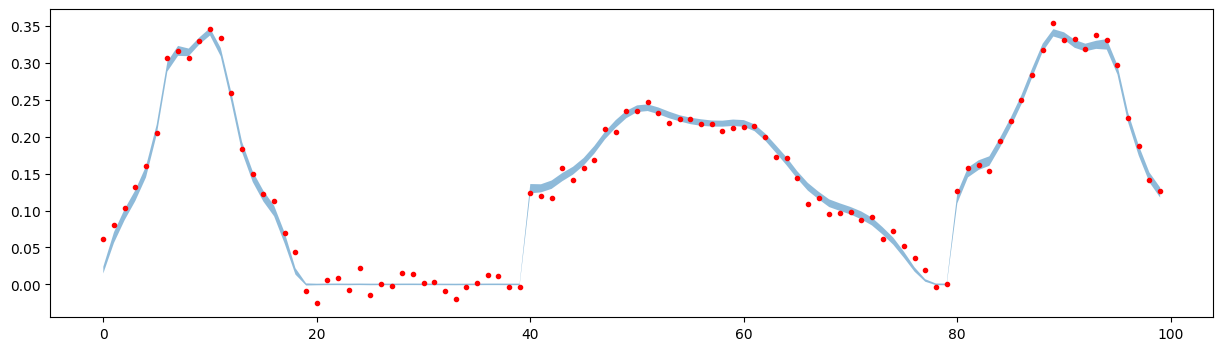

In [857]:
plt.figure(figsize=(15,4))
plt.plot(uq_data["noisy_tomo_data"], 'r.')
plt.fill_between(np.arange(0,100),
                 uq_data["mean_tomo_data"]-np.sqrt(uq_data["var_tomo_data"]),
                 uq_data["mean_tomo_data"]+np.sqrt(uq_data["var_tomo_data"]),
                 alpha=0.5)

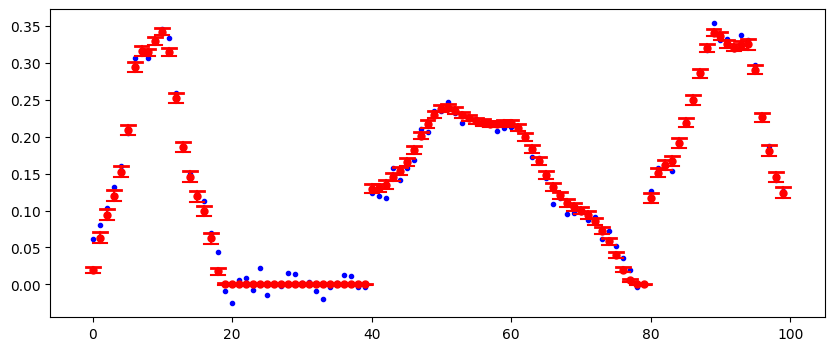

In [838]:
plt.figure(figsize=(10,4))
plt.plot(uq_data["noisy_tomo_data"], 'b.')
for i in range(uq_data["tomo_data"].size):
    tomo_plots.plot_errbar(i, uq_data["mean_tomo_data"][i], np.sqrt(uq_data["var_tomo_data"][i]))

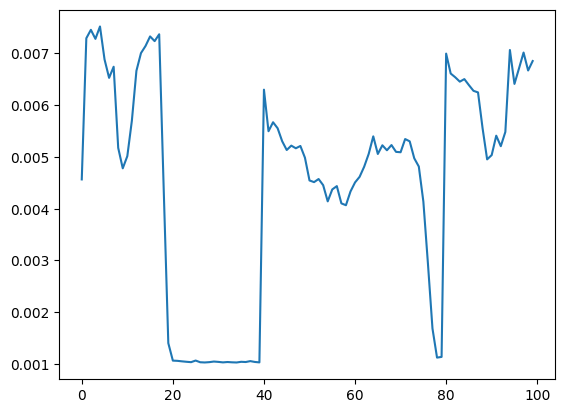

In [840]:
plt.plot( np.sqrt(uq_data["var_tomo_data"]))

In [290]:
gt_coarse = mask_core*skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
gt_coarse2 = mask_core*skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=True, mode='edge')
gt_coarse3 = mask_core*skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='constant')

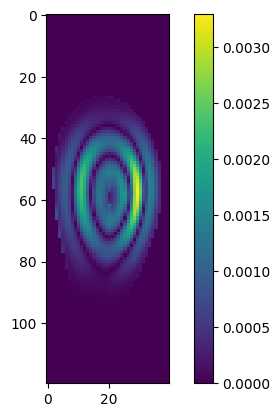

In [291]:
plt.imshow(np.abs(gt_coarse-gt_coarse2), cmap="viridis")
plt.colorbar()

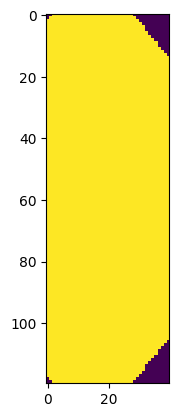

In [294]:
plt.imshow(mask_tcv)

In [ ]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch


dirname = os.path.dirname(__file__)


def plot_statistics_full(uq_data, ground_truth, psi):
    # Reshape ground truth and magnetic equilibrium if necessary
        # Reshape magnetic equilibrium if necessary
    if ground_truth.shape != uq_data["im_MAP"].shape:
        ground_truth = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
    if psi.shape != uq_data["im_MAP"].shape:
        psi = skimt.resize(psi, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
        
    fig, ax = plt.subplots(1, 3, figsize=(10,3), width_ratios=[1, 1, 1.25])
    im=ax[0].imshow(ground_truth, vmin=0, vmax=np.max(ground_truth))
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title("Ground truth")
    ax[1].axis('off')
    
    r = np.linspace(0, 40, 10)
    sxr_LoS_params = np.load(dirname + "/forward_model/sxr_LoS_params.npy")
    tcv_shape_coords = np.load(dirname + "/forward_model/tcv_shape_coords.npy")
    center = [20, 60]
    linewidth=0.5
    Lr=0.5
    Lz=1.5
    h=0.0125
    zs = np.linspace(0, Lz, round(Lz/h), endpoint=False)+0.5*h
    rs = np.linspace(0, Lr, round(Lr/h), endpoint=False)+0.5*h
    extent = copy.deepcopy(radcam.tile_extent_plot)
    extent[:,0] = extent[:,0] * rs.size - 0.5*h
    extent[:,1] = extent[:,1] * zs.size - 0.5*h
    path = Path(extent.tolist())
    patch=PathPatch(path, facecolor='none')
    #p = plt.imshow(gt, clip_path=patch, clip_on=True)
    ax[2].imshow(np.flip(gt, axis=0), origin="lower")
    #plt.colorbar()
    #plt.imshow(field_aligned_phantom)
    #plt.gca().add_patch(patch)
    #p.set_clip_path(patch)
    ax[2].axis('off')
    for i in range(LoS_params.shape[0]):
        if np.isclose(np.tan(LoS_params[i, 1]), 0, atol=1e-6):
            #plt.vlines(center[0] + LoS_params[i, 0], 0, Lz, "r")
            if center[0] + LoS_params[i, 0] < 0 or center[0] + LoS_params[i, 0] > 0.6:
                print("Vertical line does not intersect domain at x={}!".format(center[0] + LoS_params[i, 0]))
        else:
            p = LoS_params[i, 0]
            theta = LoS_params[i, 1]
            y = center[1] + p/h / np.sin(theta) - (r - center[0]) / np.tan(theta)
            # if np.min(y)>1.6 or np.max(y)<0:
            #    print("Line does not intersect domain!")
            ax[2].plot(r, y, "r", linewidth=linewidth)
    #ax[2].imshow(gt, origin="upper")
    ax[2].set_xlim([0, 40])
    ax[2].set_ylim([0, 120])
    ax[2].set_title("SXR diagnostic")

    ax[3].plot(tomo_data.T, '.', label="true")
    ax[3].plot(noisy_tomo_data.T, 'r.', label="noisy")
    ax[3].set_xlabel("LoS",  fontsize=12)
    ax[3].set_ylabel("I", rotation=0, fontsize=12, labelpad=10)
    ax[3].set_title("Tomographic data")
    ax[3].legend()
    plt.suptitle("Sample {}\n".format(s_id), fontsize=20, y=1.1)
    plt.show()

#===========================================================================

    # Reshape ground truth and magnetic equilibrium if necessary
    # Reshape magnetic equilibrium if necessary
    if ground_truth.shape != uq_data["im_MAP"].shape:
        ground_truth = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
    if psi.shape != uq_data["im_MAP"].shape:
        psi = skimt.resize(psi, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')

    fig, ax = plt.subplots(1, 7, figsize=(14,3), width_ratios=[1, 1, 1, 0.5, 2, 1, 1])
    vmin=0
    vmax=np.max(gt)
    im=ax[0].imshow(data["mean"].reshape(arg_shape), vmin=vmin, vmax=vmax)
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title(r"$\mu_{ULA}$")
    im=ax[1].imshow(np.sqrt(data["var"]).reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[1].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title(r"$\sigma_{ULA}$")
    tbp = np.abs(data["mean"]-gt.flatten())
    tbp /= np.sqrt(data["var"])
    im=ax[2].imshow(tbp.reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[2].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title(r'$\frac{\vert \mu_{ULA} -ground\_truth \vert}{\sigma_{ULA}}$')
    ax[3].axis('off')
    im = ax[4].hist(data["prads_core"], bins=int(5e2), density=True, color="b")
    ax[4].set_title(r'$P_{rad}^{core},\;ULA\;$ empirical')
    ax[4].set_xlim(xrange_prad)
    ax[4].axvline(x=prad_core_true, ymin=0, ymax=30, color='g', label=r"true $P_{rad}^{core}$")
    ax[4].legend(loc="upper left")
    ax[4].set_yticks([])

    temp_low=np.zeros(N)
    temp_low[mask_core.flatten()] = data["empirical_quantiles"][0, :]
    im=ax[5].imshow(temp_low.reshape(arg_shape), vmax=vmax)#, vmin=vmin, vmax=vmax)
    ax[5].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[5])
    ax[5].axis('off')
    ax[5].set_title("0.05 quantile")
    temp_high=np.zeros(N)
    temp_high[mask_core.flatten()] = data["empirical_quantiles"][4, :]
    im=ax[6].imshow(temp_high.reshape(arg_shape), vmax=vmax)#, vmin=vmin, vmax=vmax)
    ax[6].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[6])
    ax[6].axis('off')
    ax[6].set_title("0.95 quantile")
    plt.show()

    #print("Fraction of pixels falling withing 90%-credible interval:  {}".format(frac_pix))

    fig, ax = plt.subplots(1, 7, figsize=(14,3), width_ratios=[1, 1, 1, 0.5, 2, 1, 1])
    im=ax[0].imshow(im_MAP.reshape(arg_shape), vmin=vmin, vmax=vmax)
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title(r"$MAP$")
    im=ax[1].imshow(np.sqrt(data["var_wrtMAP"]).reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[1].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title(r"$\sigma_{MAP}$")
    tbp = np.abs(im_MAP-gt.flatten())
    tbp /= np.sqrt(data["var_wrtMAP"])
    im=ax[2].imshow(tbp.reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[2].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title(r'$\frac{\vert MAP -ground\_truth \vert}{\sigma_{MAP}}$')
    ax[3].axis('off')

    #im = ax[4].hist(data["prads_core"], bins=int(5e2), density=True, color="b")
    ax[4].set_title(r"$P_{rad}^{MAP}$ estimates")
    ax[4].set_xlim(xrange_prad)
    ax[4].axvline(x=prad_core_true, ymin=0, ymax=30, color='g', label=r"true $P_{rad}^{core}$")
    ax[4].axvline(x=data["prad_map_core"], ymin=0, ymax=30, color='r', label=r"$P_{rad}^{MAP}$")
    ax[4].legend(loc="upper left")
    ax[4].set_yticks([])
    ax[5].axis('off')
    ax[6].axis('off')
    # plot_errbar_ax(ax[4], 1, data["prad_map_core"], np.sqrt(data["var_prad_wrtMAP_core"]), left=0.1, right=0.1, col="b", linewidth=2)
    # plt.plot(1, prad_core_true, 'g.', markersize=10, label=r"true $P_{rad}^{core}$")
    # ax[4].set_xlim([0,2])
    # ax[4].set_xticks([1])
    # ax[4].set_xticklabels([r"$P_{rad}^{core}$"])
    # ax[4].legend(loc="upper left")
    # ax[4].set_title(r"$P_{rad}^{MAP}$ estimates")
    plt.show()
